In [5]:
%run ../setup_notebook.ipynb

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../dnp-code/PGM3_correct/source/numba_utilities.py", line 301:
@njit(signature, parallel=True)
def tower_sampling_C(cum_probabilities, rng, out):
^

  self.func_ir.loc))
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../dnp-code/PGM3_correct/source/numba_utilities.py", line 418:
@njit(signature1, parallel=True)


/home/thijs/repos/dnp-code/rbm_pipeline_functions.py


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5
len test inds 1665


In [146]:
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar as mpl_colorbar
import plotting_functions as pf
import analysis_functions as af
pf.set_fontsize(font_size=12)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# im_path = '/home/thijs/optogen_stim_variance.png'
# img = mpimg.imread(im_path)
# img.shape

## PCA & ICA

In [8]:
### PCA & ICA
all_nr_methods = []
weights = {}
# mapping = {}
# inverse_mapping = {}
n_comps = {'wb': 200}
bool_pca, bool_ica, bool_fa = True, False, False

def add_new_methods(name, region):
    assert weights[name].shape[0] < weights[name].shape[1]
    print(weights[name].shape, name)
#     mapping[name] = lambda high_data, w=weights[name]: np.dot(w, high_data)
#     inverse_mapping[name] = lambda low_data, w=weights[name].transpose(): np.dot(w, low_data)
    all_nr_methods.append(name)
#     low_dyn_test[name] = mapping[name](test_data[region])
#     low_dyn_train[name] = mapping[name](train_data[region])
#     low_dyn_full[name] = mapping[name](full_data[region])
    
for ir, r in enumerate(list(n_comps.keys())):
    if bool_pca:
        pca_model = sklearn.decomposition.PCA(n_components=n_comps[r])
        pca_model.fit(np.transpose(train_data[r]))
        print(pca_model)
        model_name = f'pca' 
        weights[model_name] = pca_model.components_
        add_new_methods(name=model_name, region=r)

    if bool_ica:
        ica_model = sklearn.decomposition.FastICA(n_components=n_comps[r])
        ica_model.fit(np.transpose(train_data[r]))
        print(ica_model)
        model_name = f'ica' 
        weights[model_name] = ica_model.components_
        add_new_methods(name=model_name, region=r)
    
    if bool_fa:
        fa_model = sklearn.decomposition.FactorAnalysis(n_components=n_comps[r])
        fa_model.fit(np.transpose(train_data[r]))
        print(fa_model)
        model_name = f'fa'
        weights[model_name] = fa_model.components_
        add_new_methods(name=model_name, region=r)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
(200, 52518) pca


In [9]:
rbm_path = '/media/thijs/hooghoudt/new_sweep_april20/RBM_sweep_reruns/RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data'
RBM = pickle.load(open(rbm_path, 'rb'))
weights['rbm'] = RBM.weights.copy()

In [10]:
plot_methods = [ 'pca', 'rbm']
weighted_labels = {}

plot_labels = rec.labels[inds_wb, :].A
ind_regions = set(np.where(plot_labels.sum(0))[0])
ind_regions = np.array(list(ind_regions.difference(set([0, 93, 113, 218, 219, 220, 221, 222, 223, 224, 259, 274]))))
plot_labels = np.squeeze(plot_labels[:, ind_regions])


sparsity_vector = {}
part_ratio_activity = {x: np.zeros(test_data['wb'].shape[1]) for x in ['rbm', 'pca']}
for dr in plot_methods:
    sparsity_vector[dr] = np.zeros(weights[dr].shape[0])
    for mu in range(weights['rbm'].shape[0]):
        weighted_labels[dr] = af.freq_distr_weighted_regions(w_vector=weights[dr][mu, :], m_labels=plot_labels)
        sparsity_vector[dr][mu] = af.p_metric_per_hu(weighted_labels[dr]) * len(weighted_labels[dr])
for t in range(test_data['wb'].shape[1]):
    pc_act = np.dot(weights['pca'], test_data['wb'][:, t])
    part_ratio_activity['pca'][t] = af.p_metric_per_hu(pc_act)
    hu_act = RBM.mean_hiddens(test_data['wb'][:, t].T)
    part_ratio_activity['rbm'][t] = af.p_metric_per_hu(hu_act)

/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


In [ ]:
# plt.rcParams['figure.figsize'] = (5, 4)
# for k, v in part_ratio_activity.items():
#     plt.hist(v, bins=50, histtype='step', label=k)
# plt.legend()

In [237]:
## Uniformity of connectivity:

## Original metric:
# w_th_arr, curve_NVUgeqKw, sh_curve_NVUgeqKw = {}, {}, {}
# print(f'Methods: {plot_methods}')
# for dr in plot_methods:
#     print(f'calculating {dr}')
#     w_th_arr[dr], curve_NVUgeqKw[dr], sh_curve_NVUgeqKw[dr] = af.count_connections(weight_matrix=weights[dr],
#                                                                                 n_w_th=250, perc_top=100)

## New metric:
all_w_arrs, all_sh_w_arrs, all_cdfs, all_sh_cdfs = {}, {}, {}, {}
print(f'Methods: {plot_methods}')
for dr in plot_methods:
    print(f'calculating {dr}')
    all_w_arrs[dr], all_sh_w_arrs[dr], all_cdfs[dr], all_sh_cdfs[dr] = af.count_connections_2(weight_matrix=weights[dr],
                                                                                n_w_th=250)

Methods: ['pca', 'rbm']
calculating pca


11it [00:19,  1.77s/it]


calculating rbm


11it [00:16,  1.50s/it]


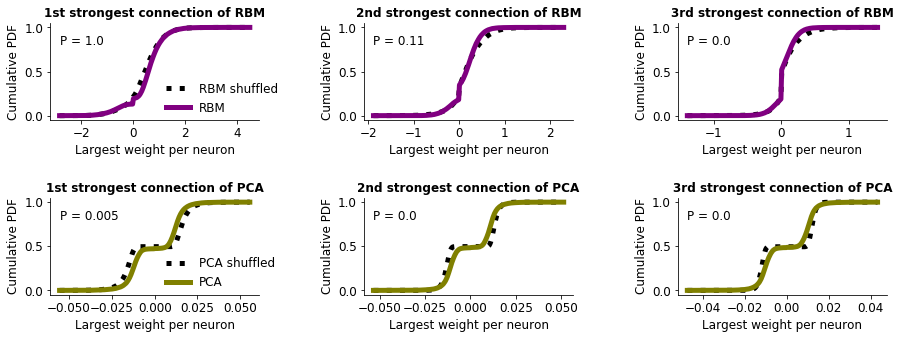

In [239]:
## Supplemental figure of uniform

plt.rcParams['figure.figsize'] = (15, 5)
plt.subplots_adjust(hspace=0.8, wspace=0.5)
ax_unif_dict = {}
dict_str_number = {0: '1st', 1: '2nd', 2: '3rd'}
for i_dr, dr in enumerate(['rbm', 'pca']):
    for i_k, k_value in enumerate([0, 1, 2]):
        i_plot = 1 + i_k + (3 * i_dr)
        ax_unif_dict[i_plot] = plt.subplot(2, 3, i_plot)
        _ = pf.plot_uniform_distr(w_mat=all_w_arrs, sh_w_mat=all_sh_w_arrs,
                                  cdf_mat=all_cdfs, sh_cdf_mat=all_sh_cdfs,
                                  k_value=k_value, dr=dr, print_pval=True,
                                  plot_legend=(i_k == 0), ax=ax_unif_dict[i_plot])

In [206]:
for dr in plot_methods:
    for kk in range(all_cdfs[dr].shape[0]):
        distr = all_cdfs[dr][kk, :]
        sh_distr = all_sh_cdfs[dr][kk, :]
        print(f'{dr}: K = {kk} P value = {np.round(scipy.stats.ks_2samp(distr, sh_distr)[1], 3)}')


pca: K = 0 P value = 0.155
pca: K = 1 P value = 0.036
pca: K = 2 P value = 0.002
pca: K = 3 P value = 0.001
pca: K = 4 P value = 0.0
pca: K = 5 P value = 0.0
pca: K = 6 P value = 0.0
pca: K = 7 P value = 0.0
pca: K = 8 P value = 0.0
pca: K = 9 P value = 0.0
pca: K = 10 P value = 0.0
rbm: K = 0 P value = 1.0
rbm: K = 1 P value = 0.368
rbm: K = 2 P value = 0.024
rbm: K = 3 P value = 0.078
rbm: K = 4 P value = 0.078
rbm: K = 5 P value = 0.016
rbm: K = 6 P value = 0.368
rbm: K = 7 P value = 0.016
rbm: K = 8 P value = 0.001
rbm: K = 9 P value = 0.0
rbm: K = 10 P value = 0.0


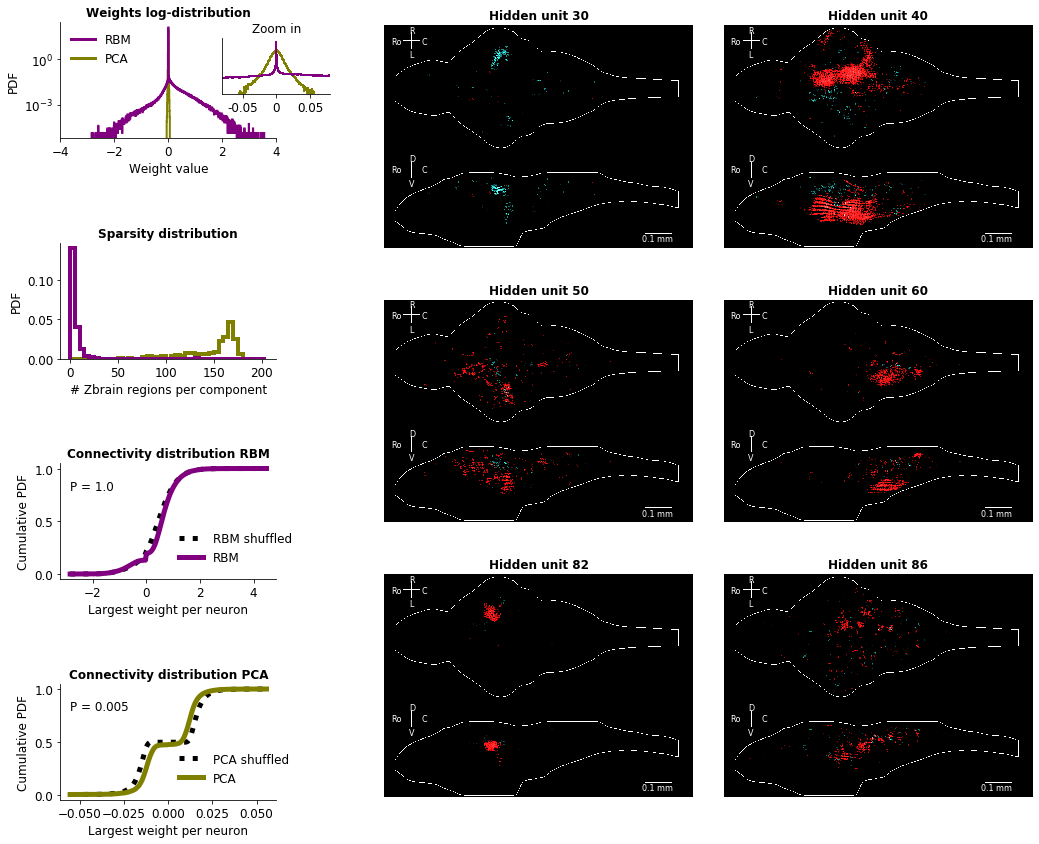

In [253]:
plt.rcParams['figure.figsize'] = (15, 12)
save_fig = True

mu_arr = [30, 40, 50, 60, 82, 86]
plot_inds = [2, 3, 5, 6]
fig = plt.figure(constrained_layout=False)
gs_stats = fig.add_gridspec(ncols=1, nrows=4, bottom=0.05, top=0.95, 
                         hspace=0.9, wspace=0.0, left=0.05, right=0.25)  # [1, 2.2, 1.2]
gs_im = fig.add_gridspec(ncols=2, nrows=3, bottom=0.05, top=0.95, 
                         hspace=0.2, wspace=0.1, left=0.35, right=0.95)  # [1, 2.2, 1.2]

## example  plots
sax = {} 
for i_mu, mu in enumerate(mu_arr):
    sax[i_mu] = fig.add_subplot(gs_im[i_mu])
    pf.plot_example_hu(ax=sax[i_mu], hu_id=mu, fontsize=8)

## Old example plots, using mu_arr = dict('rbm' : [0, 2]) etc
# sax = {}; iplot=0
# # time_slice = slice(0, 500)
# for i_dr, dr in enumerate(plot_methods):
#     for i_mu, mu in enumerate(mu_arr[dr]):
#         weighted_labels[dr] = freq_distr_weighted_regions(w_vector=weights[dr][mu, :], m_labels=plot_labels)
#         iplot += 1
#         sax[iplot] = plt.subplot(9, 5, int(i_dr + 3 + (i_mu*15)))
#     #         sax[iplot].plot(weighted_labels[dr], label=f'{dr_legend[dr]}, S={np.round(freq_entropy(weighted_labels[dr]), 2)}',
#     #                         linewidth=1, alpha=1, color=dr_colors[dr])
# #         sax[iplot].plot(low_dyn_test[dr][mu, time_slice], linewidth=1, color=dr_colors[dr])
# #         sax[iplot].get_yaxis().set_visible(False); sax[iplot].get_yaxis().set_ticks([])
# #         sax[iplot].get_xaxis().set_visible(False); sax[iplot].get_xaxis().set_ticks([])
#     #     plt.xlabel('Region id'); #plt.ylabel('P(region)'); plt.title(f'Example P(region) for HU {mu}')
#         if i_dr == 1 and i_mu == 0:
#             plt.title('Example components and time traces')

## Sparsity of regions
ax_spars = fig.add_subplot(gs_stats[1])
plot_bins = np.arange(0, len(ind_regions), 5)
for dr in plot_methods:
    #     plt.hist(sparsity_vector[dr], bins=plot_bins, label=dr)
    sns.distplot(sparsity_vector[dr], hist=True, kde=False, bins=plot_bins,
                 label=dr_legend[dr], color=dr_colors[dr], ax=ax_spars,
                 kde_kws={'linewidth': 4}, hist_kws={'histtype':'step', 'linewidth':4, 'alpha':1, 'density':True})  # prev alpha 0.7 lw 2
ax_spars.set_xlabel('# Zbrain regions per component'); 
ax_spars.set_ylabel('PDF'); 
ax_spars.set_title('Sparsity distribution', fontdict={'weight': 'bold'});
ax_spars.spines['top'].set_visible(False)
ax_spars.spines['right'].set_visible(False)

## Weights distribution
ax_mainw = fig.add_subplot(gs_stats[0])
plot_bins = np.linspace(np.min([weights[x].min() for x in weights.keys()]), 
                        np.max([weights[x].max() for x in weights.keys()]), 1000)
for dr in plot_methods:
    ax_mainw.hist(np.ravel(weights[dr]), bins=plot_bins, histtype='step', label=dr_legend[dr],
             density=True, linewidth=2, color=dr_colors[dr])
ax_mainw.set_yscale('log'); ax_mainw.set_xlabel('Weight value'); 
ax_mainw.set_ylabel('PDF'); 
ax_mainw.set_title('Weights log-distribution', fontdict={'weight': 'bold'})
ax_mainw.set_xlim([-4, 4])
ax_mainw.spines['top'].set_visible(False)
ax_mainw.spines['right'].set_visible(False)
handle_dict = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['rbm', 'pca']}
ax_mainw.legend(handles=[handle_dict['rbm'], handle_dict['pca']],
                labels=[dr_legend['rbm'], dr_legend['pca']],
                frameon=False, loc='upper left');

## Weights distribution Zoom inset
ax_zoomw = ax_mainw.inset_axes([0.75, 0.38, 0.5, 0.48])
for dr in plot_methods:
    ax_zoomw.hist(np.ravel(weights[dr]), bins=np.linspace(-0.11, 0.11, 500), 
                  histtype='step', label=dr_legend[dr],
                  density=True, linewidth=2, color=dr_colors[dr])
ax_zoomw.get_yaxis().set_visible(False);
ax_zoomw.get_xaxis().set_ticklabels(['', '-0.05', '0', '0.05'])
ax_zoomw.set_yscale('log'); ax_zoomw.set_xlim([-0.08, 0.08]); 
ax_zoomw.set_ylim([1e-4, 5e3])
ax_zoomw.set_title('Zoom in')
ax_zoomw.spines['top'].set_visible(False)
ax_zoomw.spines['right'].set_visible(False)

## Uniformity plots
ax_unif = {}
for i_dr, dr in enumerate(['rbm', 'pca']):
    ax_unif[i_dr] = fig.add_subplot(gs_stats[2 + i_dr])
    pf.plot_uniform_distr(w_mat=all_w_arrs, sh_w_mat=all_sh_w_arrs,
                          cdf_mat=all_cdfs, sh_cdf_mat=all_sh_cdfs,
                          k_value=0, dr=dr, print_pval=True,
                          plot_legend=True, ax=ax_unif[i_dr])
    ax_unif[i_dr].set_title(f'Connectivity distribution {dr_legend[dr]}',
                            fontdict={'weight': 'bold'})

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_2.pdf', dpi=500, bbox_inches='tight')

In [254]:

def opt_leaf(w_mat, dim=0):
    '''create optimal leaf order over dim, of matrix w_mat. if w_mat is not an
    np.array then its assumed to be a RNN layer. see also: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.optimal_leaf_ordering.html#scipy.cluster.hierarchy.optimal_leaf_ordering'''
    if type(w_mat) != np.ndarray:  # assume it's an rnn layer
        w_mat = [x for x in w_mat.parameters()][0].detach().numpy()
    assert w_mat.ndim == 2
    if dim == 1:  # transpose to get right dim in shape
        w_mat = w_mat.T
    dist = scipy.spatial.distance.pdist(w_mat, metric='euclidean')  # distanc ematrix
    link_mat = scipy.cluster.hierarchy.ward(dist)  # linkage matrix
    opt_leaves = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.optimal_leaf_ordering(link_mat, dist))
    return opt_leaves
hu_act_test = np.transpose(RBM.mean_hiddens(test_data['wb'].T))

ol = opt_leaf(hu_act_test)
hu_act_test_remap = hu_act_test[ol, :]

/home/thijs/repos/dnp-code/PGM3_correct/source/layer.py:1152: RuntimeWarning: overflow encountered in true_divide
  ) / (etg_plus / np.sqrt(self._gamma_plus)))


In [255]:
median_hu_period = np.zeros((200, 2))

for mu in range(200):
    tmp = np.sign(hu_act_test_remap[mu, :])  # +1 or -1, as bimodality is around 0
    tmp_inds = np.where(tmp[1:] - tmp[:-1])[0] # where non zero? = state change
#     tmp_inds
    duration_1 = tmp_inds[1::2] - tmp_inds[:-1:2]  # skip 1 to only get 1 state type.
    duration_2 = tmp_inds[2::2] - tmp_inds[1:-1:2]  # get the other type
#     plt.hist(duration_1, histtype='step', density=True, label='1')
#     plt.hist(duration_2, histtype='step', density=True, label='2')
#     print(f'Median: {np.median(duration_1), np.median(duration_2)}')
#     print(f'Mean: {np.mean(duration_1), np.mean(duration_2)}')
    median_hu_period[mu, 0] = np.maximum(np.median(duration_1), np.median(duration_2))
    median_hu_period[mu, 1] = np.minimum(np.median(duration_1), np.median(duration_2))

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


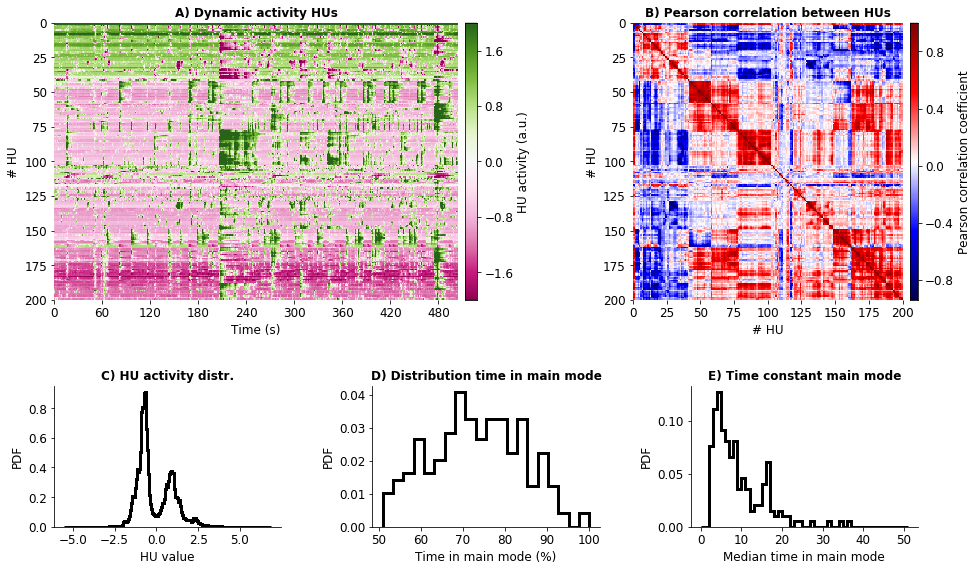

In [269]:
plt.rcParams['figure.figsize'] = (12, 7)
save_fig = True
freq = 1 / np.mean(np.diff(rec.time))

fig = plt.figure(constrained_layout=False)
gs = {}
gs[0] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.45, top=1, left=0, right=0.49)
gs[1] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.45, top=1, left=0.67, right=1)
# gs[2] = fig.add_gridspec(ncols=1, nrows=6, bottom=0.0, top=0.5, left=0, right=0.49)
gs[2] = fig.add_gridspec(ncols=3, nrows=1, bottom=0, top=0.28, left=0, right=1, wspace=0.4)

## Dynamic activity raster plot
ax_raster = fig.add_subplot(gs[0][0])
sns.heatmap(hu_act_test_remap, vmin=-2, vmax=2, cbar=False, cmap='PiYG', ax=ax_raster)
ax_raster.set_yticks([x * 25 for x in range(9)])
ax_raster.set_yticklabels(ax_raster.get_yticks())
ax_raster.set_xticks([x * int(60 * freq) for x in range(9)])
ax_raster.set_xticklabels((np.round(ax_raster.get_xticks() / freq)).astype('int'),
                          rotation=0)
ax_raster.set_title('A) Dynamic activity HUs', fontdict={'weight': 'bold'})
ax_raster.set_xlabel('Time (s)'); ax_raster.set_ylabel('# HU')
divider = make_axes_locatable(ax_raster)
cax_rast = divider.append_axes('right', size='3%', pad=0.1)
mpl_colorbar(ax_raster.get_children()[0], cax=cax_rast)
cax_rast.yaxis.set_ticks_position('right')
cax_rast.set_ylabel(r'HU activity (a.u.)')

## Pearson correlation plot
ax_corr = fig.add_subplot(gs[1][0])
corr_mat_hus = np.corrcoef(hu_act_test_remap)
sns.heatmap(corr_mat_hus, cmap='seismic', cbar=False, ax=ax_corr)
ax_corr.set_title('B) Pearson correlation between HUs', fontdict={'weight': 'bold'})
ax_corr.set_xlabel('# HU'); ax_corr.set_ylabel('# HU');
ax_corr.set_xticks([x * 25 for x in range(9)])
ax_corr.set_xticklabels(ax_raster.get_yticks(), rotation=0)
ax_corr.set_yticks([x * 25 for x in range(9)])
ax_corr.set_yticklabels(ax_raster.get_yticks())
divider = make_axes_locatable(ax_corr)
cax_corr = divider.append_axes('right', size='3%', pad=0.1)
mpl_colorbar(ax_corr.get_children()[0], cax=cax_corr)
cax_corr.yaxis.set_ticks_position('right')
cax_corr.set_ylabel(r'Pearson correlation coefficient')

## Distirbution of HU activity
ax_hist_act = fig.add_subplot(gs[2][0])
ax_hist_act.hist(hu_act_test_remap.flatten(), bins=200, histtype='step', 
                 linewidth=3, color='k', density=True);
ax_hist_act.set_xlabel('HU value'); ax_hist_act.set_ylabel('PDF');
ax_hist_act.set_title('C) HU activity distr.', weight='bold')
ax_hist_act.spines['right'].set_visible(False)
ax_hist_act.spines['top'].set_visible(False)

##
ax_hist_reside_main = fig.add_subplot(gs[2][1])
fract_geq0 = (hu_act_test_remap >= 0).mean(1)  # fraction of time points where value >= 0 for each hu
fract_main = np.abs(fract_geq0 - 0.5) + 0.5  # mirror at 0.5 for all points below 0.5
ax_hist_reside_main.hist(fract_main * 100, bins=20, histtype='step', linewidth=3,
                         color='k', density=True)
ax_hist_reside_main.set_xlabel('Time in main mode (%)')
ax_hist_reside_main.set_ylabel('PDF');
ax_hist_reside_main.set_title('D) Distribution time in main mode', weight='bold')
ax_hist_reside_main.set_xticks([x * 10 for x in range(5, 11)])
ax_hist_reside_main.spines['right'].set_visible(False)
ax_hist_reside_main.spines['top'].set_visible(False)

ax_hist_inter_mainstate = fig.add_subplot(gs[2][2])
ax_hist_inter_mainstate.hist(median_hu_period[:, 0], density=True, 
                             bins=np.arange(np.nanmax(median_hu_period)),
                             histtype='step', color='k', alpha=1, linewidth=3)
ax_hist_inter_mainstate.set_xlabel('Median time in main mode')
ax_hist_inter_mainstate.set_ylabel('PDF')
ax_hist_inter_mainstate.set_title('E) Time constant main mode', weight='bold')
ax_hist_inter_mainstate.spines['right'].set_visible(False)
ax_hist_inter_mainstate.spines['top'].set_visible(False)


# ax_hist_inter_sidestate = fig.add_subplot(gs[2][3])
# ax_hist_inter_mainstate.hist(median_hu_period[:, 1], density=True, 
#                              bins=np.arange(np.nanmax(median_hu_period)),
#                              histtype='step', color='k', alpha=0.7, linewidth=3)
# ax_hist_inter_sidestate.set_xlabel('Median time in alternative mode')
# ax_hist_inter_sidestate.set_ylabel('PDF')
# ax_hist_inter_sidestate.set_title('F) Time constant alternative mode', weight='bold')
# ax_hist_inter_sidestate.spines['right'].set_visible(False)
# ax_hist_inter_sidestate.spines['top'].set_visible(False)

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_4.pdf', bbox_inches='tight')

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


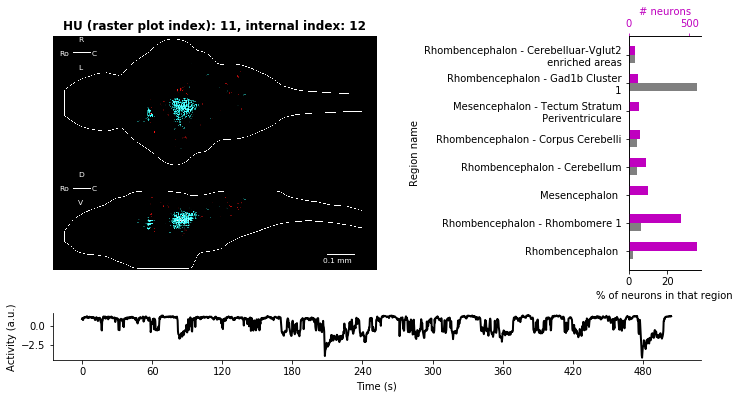

In [235]:
## Show one HU
tmp = pf.plot_info_hu(raster_order=ol, hu_activity=hu_act_test, mu=12, save_fig=False, region_absolute=True,
                          RBM=RBM, rec=rec, selection_neurons=selected_neurons['wb'])

In [238]:
## Save all Hidden Units 

plt.rcParams['figure.figsize'] = (10, 5)
for hu_ind in tqdm(range(200)):
    tmp = pf.plot_info_hu(raster_order=ol, hu_activity=hu_act_test, mu=hu_ind, save_fig=True,
                          region_absolute=False,
                          RBM=RBM, rec=rec, selection_neurons=selected_neurons['wb'])
    plt.close(tmp) # close to prevent plotting of all HUs


100%|██████████| 200/200 [04:17<00:00,  1.29s/it]


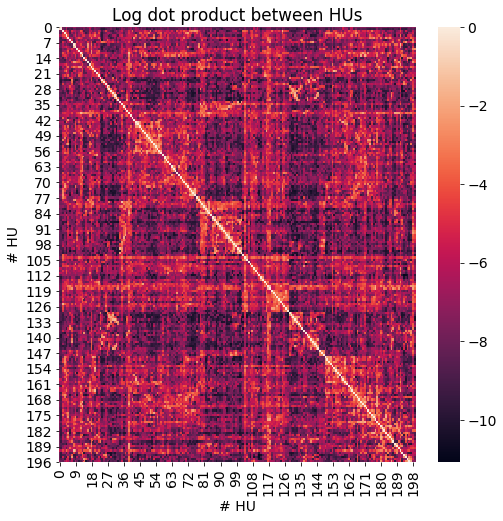

In [22]:
def adj_weights(weights):
    assert weights.shape[1] > weights.shape[0]
    tmp = np.abs(weights)
    mat = tmp.dot(tmp.T)
#     print(mat.shape)
    norm_els = np.diag(mat)
    norm_mat = norm_els[:, np.newaxis] + norm_els[np.newaxis, :]
    result = 2 * mat / norm_mat
#     np.fill_diagonal(result, 0.01)
    return result
    
adj_mat = adj_weights(RBM.weights[ol, :])

plt.rcParams['figure.figsize'] = (8, 8)
sns.heatmap(np.log(adj_mat))
plt.xlabel('# HU')
plt.ylabel('# HU')
plt.title('Log dot product between HUs');

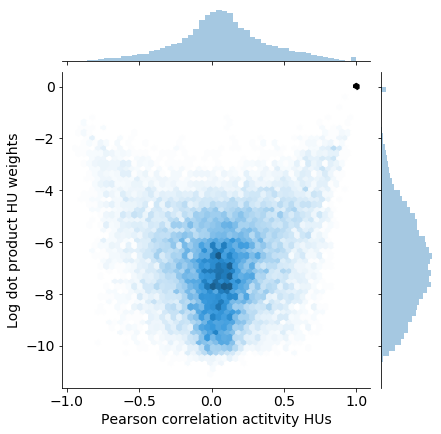

In [19]:

jp = sns.jointplot(corr_mat_hus.ravel(), np.log(adj_mat.ravel()), kind='hex')
jp.set_axis_labels('Pearson correlation actitvity HUs', 
                   'Log dot product HU weights')